# TIME SERIES PREDICTION STATEWISE -- KERALA, MAHARASHTRA (in depth analysis) and DELHI  - TILL 29th APRIL 2020

In [9]:
!pip install pandas

In [10]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn import preprocessing
import mplcursors
import datetime
from pmdarima.arima import auto_arima
from fbprophet import Prophet
import statsmodels.api as sm
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from tslearn.svm import TimeSeriesSVR
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate

In [11]:
from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras import Sequential

In [42]:
#https://machinelearningmastery.com/make-sample-forecasts-arima-python/
states =['Kerala', 'Delhi', 'Telengana', 'Haryana', 'Rajasthan', 'Uttar Pradesh',
 'Tamil Nadu', 'Ladakh', 'Karnataka', 'Maharashtra', 'Punjab',
 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand', 'Odisha', 'Puducherry',
 'West Bengal', 'Chhattisgarh', 'Chandigarh', 'Gujarat', 'Himachal Pradesh',
 'Madhya Pradesh', 'Bihar', 'Manipur', 'Mizoram',
 'Andaman and Nicobar Islands', 'Goa', 'Assam', 'Jharkhand',
 'Arunachal Pradesh', 'Tripura', 'Meghalaya']

In [43]:
df_state_recs =[]

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

for j in range(0, len(states)):
    stateName = states[j]
    df_per_State_features = pd.read_csv('features/' + stateName +'.csv')
    df_per_State_features = df_per_State_features.fillna(0)
    df_per_State_features["Active Cases"].replace({0:1}, inplace=True)
    df_state_recs.append(df_per_State_features)

# Analysis for Maharashtra

In [44]:
df_per_State_features = df_state_recs[9]
stateName = states[9]
data = df_per_State_features['Active Cases'].astype('int').values
    
daterange = df_per_State_features['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]


pred_index= pd.date_range(start=dateStart, end=dateEnd, freq='D')
activecases = pd.Series(data, pred_index)
len_forecast = np.shape(df_per_State_features['Active Cases'])[0]
print(dateStart, dateEnd)

2020-03-09 2020-04-29


(737485.0, 737546.0)

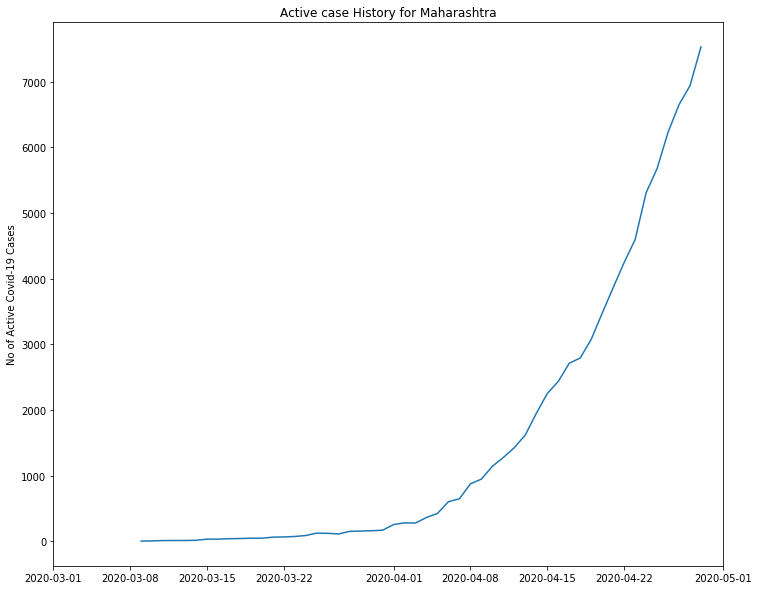

In [45]:
f, ax = plt.subplots(1,1 , figsize=(12,10))
plt.plot(activecases)
ax.set_ylabel("No of Active Covid-19 Cases")
title = 'Active case History for ' + stateName
ax.set_title(title)
ax.set_xlim([datetime.date(2020, 3, 1), datetime.date(2020, 5, 1)])


# Deep Learning based LSTM prediction for Active Cases using Input Features Cured/Discharged/Migrated', 'Death', 'Total Confirmed cases', 'LiteracyRate', 'PopulationDensity', 'ElderlyRate','DistrictsEffected', 'NoRedZones', 'NoOrangeZones', 'NoGreenZones, InternationalAirports,IntAirportPassenger,StateHospitals,StateHospitalBeds,StateHospitalICUs,StateHospitalVentilators for State Maharashtra

In [46]:
df_per_State_features = df_state_recs[9]
df_per_State_features.head()

,Unnamed: 0,index,Date,Name of State / UT,Cured/Discharged/Migrated,Death,Total Confirmed cases,Active Cases,LiteracyRate,PopulationDensity,...,StateHospitals,StateHospitalBeds,StateHospitalICUs,StateHospitalVentilators,Rate_per_3_days,Rate_per_5_days,Rate_per_7_days,Rate_per_15_days,Rate_per_21_days,is_curve_flattened
0,0,76,2020-03-09,Maharashtra,0,0,2,2,82.3,365,...,3203,231739,11587,5793,0.00,0.0,0.0,0.0,0.0,0
1,1,88,2020-03-10,Maharashtra,0,0,5,5,82.3,365,...,3203,231739,11587,5793,0.00,0.0,0.0,0.0,0.0,0
2,2,100,2020-03-11,Maharashtra,0,0,10,10,82.3,365,...,3203,231739,11587,5793,0.00,0.0,0.0,0.0,0.0,0
3,3,113,2020-03-12,Maharashtra,0,0,11,11,82.3,365,...,3203,231739,11587,5793,81.82,0.0,0.0,0.0,0.0,0
4,4,126,2020-03-13,Maharashtra,0,0,11,11,82.3,365,...,3203,231739,11587,5793,54.55,0.0,0.0,0.0,0.0,0


In [47]:
df_per_State_features = df_per_State_features[['Cured/Discharged/Migrated', 'Death', 'Total Confirmed cases', 'LiteracyRate', 'PopulationDensity', 'ElderlyRate',
       'DistrictsEffected', 'NoRedZones', 'NoOrangeZones', 'NoGreenZones', 'InternationalAirports', 'IntAirportPassenger', 'StateHospitals','StateHospitalBeds','StateHospitalICUs', 'StateHospitalVentilators', 'Active Cases']]

In [48]:
df_per_State_features.head()
np.shape(df_per_State_features)

(52, 17)

In [49]:

# # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:
no_features = df_per_State_features.shape[1] - 1 #(subtracting the predicted output)

values = df_per_State_features.values
# ensure all data is float
values = values.astype('float32')
print(np.shape(values)[0])
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
print(np.shape(reframed))
reframed.drop(reframed.columns[[18, 19, 20, 21,22,23,24,25,26,27,28,29,30, 31, 32, 33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
split_factor = int(df_per_State_features.shape[0]*0.65)
train = values[:split_factor, :]
test = values[split_factor:, :]

print(np.shape(train))
print(np.shape(test))

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

print(train_X.shape[1], train_X.shape[2])

52
(51, 34)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0   0.000000        0.0        0.0        0.0   
2        0.0        0.0   0.000322        0.0        0.0        0.0   
3        0.0        0.0   0.000859        0.0        0.0        0.0   
4        0.0        0.0   0.000966        0.0        0.0        0.0   
5        0.0        0.0   0.000966        0.0        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        0.0        0.0         0.0         0.0         0.0   
2        0.0        0.0        0.0         0.0         0.0         0.0   
3        0.0        0.0        0.0         0.0         0.0         0.0   
4        0.0        0.0        0.0         0.0         0.0         0.0   
5        0.0        0.0        0.0         0.0         0.0         0.0   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var1(t)  
1         0.0         0.0         0.0      

In [28]:
# design network
model = Sequential()

model.add(LSTM(units=50, return_sequences= True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=64, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

Train on 33 samples, validate on 18 samples
Epoch 1/300
33/33 - 5s - loss: 0.0206 - val_loss: 0.4477
Epoch 2/300
33/33 - 0s - loss: 0.0206 - val_loss: 0.4457
Epoch 3/300
33/33 - 0s - loss: 0.0206 - val_loss: 0.4445
Epoch 4/300
33/33 - 0s - loss: 0.0206 - val_loss: 0.4438
Epoch 5/300
33/33 - 0s - loss: 0.0206 - val_loss: 0.4435
Epoch 6/300
33/33 - 0s - loss: 0.0205 - val_loss: 0.4436
Epoch 7/300
33/33 - 0s - loss: 0.0205 - val_loss: 0.4438
Epoch 8/300
33/33 - 0s - loss: 0.0204 - val_loss: 0.4442
Epoch 9/300
33/33 - 0s - loss: 0.0203 - val_loss: 0.4448
Epoch 10/300
33/33 - 0s - loss: 0.0202 - val_loss: 0.4456
Epoch 11/300
33/33 - 0s - loss: 0.0209 - val_loss: 0.4435
Epoch 12/300
33/33 - 0s - loss: 0.0202 - val_loss: 0.4414
Epoch 13/300
33/33 - 0s - loss: 0.0202 - val_loss: 0.4395
Epoch 14/300
33/33 - 0s - loss: 0.0201 - val_loss: 0.4376
Epoch 15/300
33/33 - 0s - loss: 0.0201 - val_loss: 0.4357
Epoch 16/300
33/33 - 0s - loss: 0.0201 - val_loss: 0.4339
Epoch 17/300
33/33 - 0s - loss: 0.020

Epoch 141/300
33/33 - 0s - loss: 0.0042 - val_loss: 0.0776
Epoch 142/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0773
Epoch 143/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0777
Epoch 144/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0786
Epoch 145/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0792
Epoch 146/300
33/33 - 0s - loss: 0.0042 - val_loss: 0.0795
Epoch 147/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0795
Epoch 148/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0792
Epoch 149/300
33/33 - 0s - loss: 0.0042 - val_loss: 0.0785
Epoch 150/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0776
Epoch 151/300
33/33 - 0s - loss: 0.0042 - val_loss: 0.0766
Epoch 152/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0754
Epoch 153/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0740
Epoch 154/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0733
Epoch 155/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0725
Epoch 156/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.0714
Epoch 157/300
33/33 - 0s - loss: 0.0041 - val_loss: 0.07

Epoch 280/300
33/33 - 0s - loss: 0.0032 - val_loss: 0.0814
Epoch 281/300
33/33 - 0s - loss: 0.0030 - val_loss: 0.0836
Epoch 282/300
33/33 - 0s - loss: 0.0030 - val_loss: 0.0856
Epoch 283/300
33/33 - 0s - loss: 0.0030 - val_loss: 0.0863
Epoch 284/300
33/33 - 0s - loss: 0.0030 - val_loss: 0.0854
Epoch 285/300
33/33 - 0s - loss: 0.0031 - val_loss: 0.0885
Epoch 286/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.0902
Epoch 287/300
33/33 - 0s - loss: 0.0030 - val_loss: 0.0902
Epoch 288/300
33/33 - 0s - loss: 0.0030 - val_loss: 0.0926
Epoch 289/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.0941
Epoch 290/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.0942
Epoch 291/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.0934
Epoch 292/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.0945
Epoch 293/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.0974
Epoch 294/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.0986
Epoch 295/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.1017
Epoch 296/300
33/33 - 0s - loss: 0.0029 - val_loss: 0.10

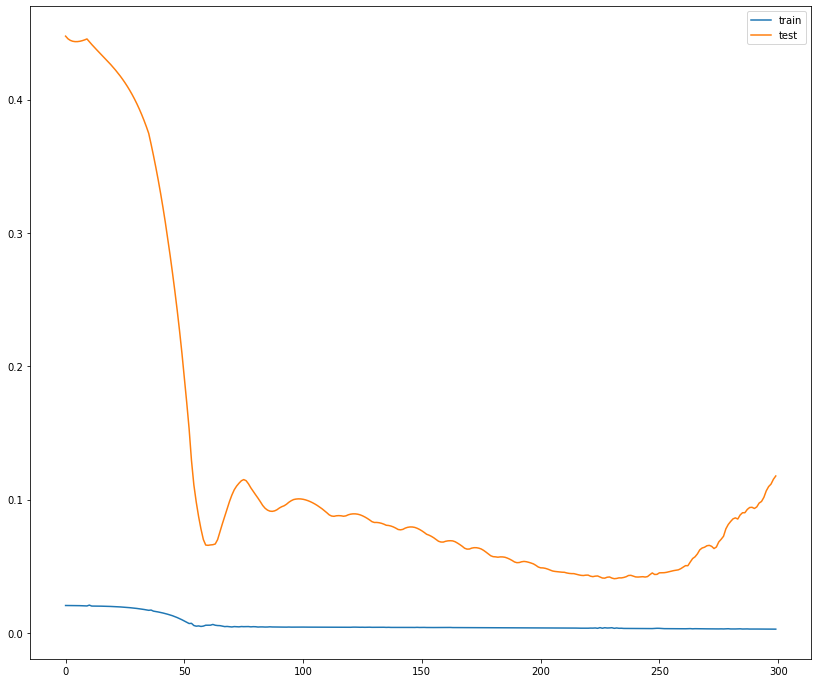

In [29]:
# plot train vs validation loss
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# make a prediction
y_predict = model.predict(test_X)
print(y_predict)
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print(rmse)

(33, 1, 17) (33,) (18, 1, 17) (18,)
[[0.17533599]
 [0.19870947]
 [0.21865927]
 [0.23935153]
 [0.27530047]
 [0.30890933]
 [0.3230589 ]
 [0.35032755]
 [0.38725105]
 [0.50754976]
 [0.57228047]
 [0.70725536]
 [0.78019655]
 [0.8516881 ]
 [0.87629485]
 [1.0850812 ]
 [1.1130618 ]
 [1.2872244 ]]
0.14587346


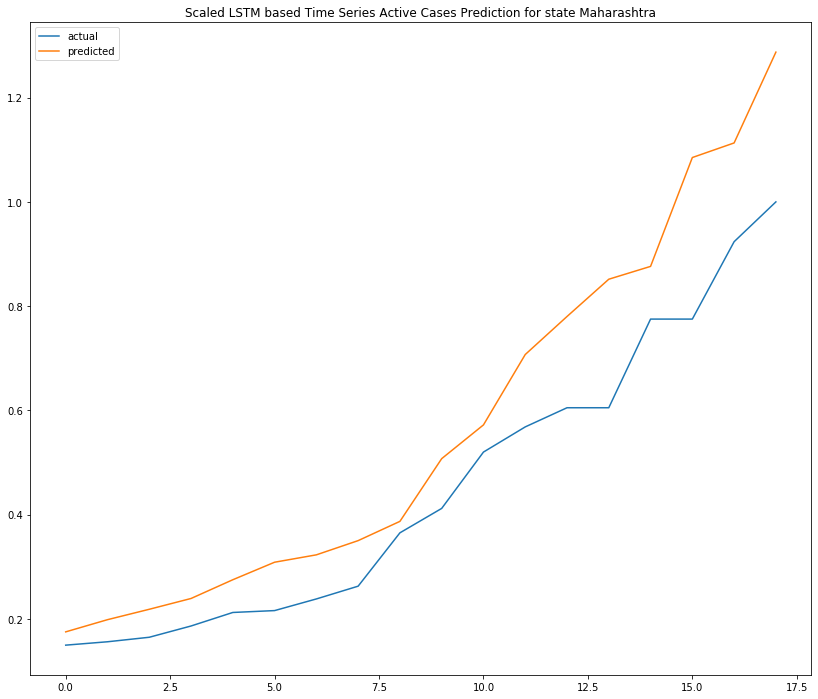

In [31]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# Invert Scaling to get actual predicted values and compare with Actual Number of Predicted Cases

In [32]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

print(inv_y)

Test RMSE: 202.472
[ 207.99998  217.       229.       259.       295.       300.
  331.       365.       507.       572.       722.       789.
  840.       840.      1076.      1076.      1282.      1388.     ]


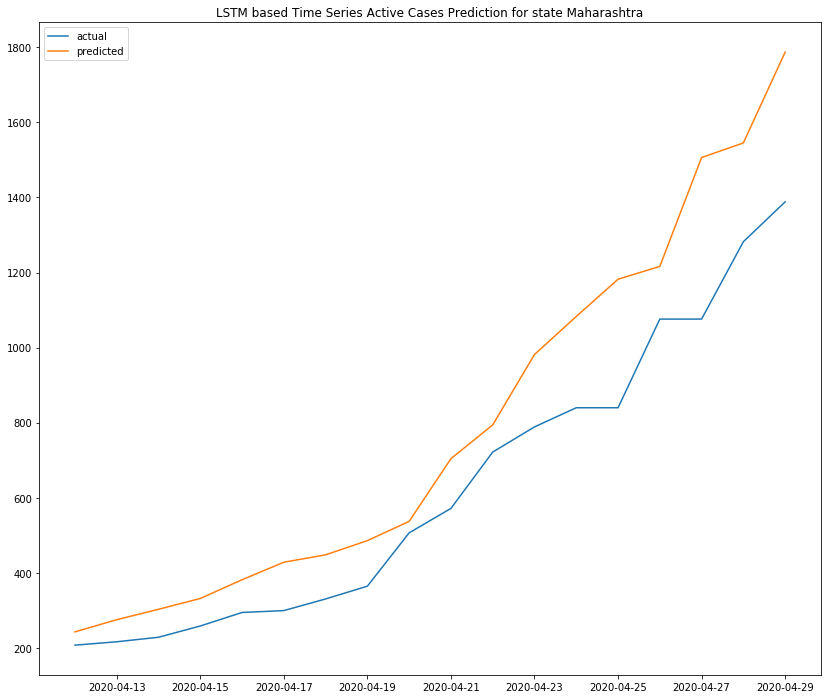

In [33]:
# plot actual vs predicted
pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)

plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# Deep Learning based LSTM prediction for Active Cases using Input Features Cured/Discharged/Migrated', 'Death', 'Total Confirmed cases', 'LiteracyRate'

In [34]:
#with Limited set of features , the last few features 'LiteracyRate', 'PopulationDensity', 'ElderlyRate' are constants over time
df_per_State_features_lstm = df_state_recs[9]
df_per_State_features_lstm = df_per_State_features_lstm[['Cured/Discharged/Migrated', 'Death', 'Total Confirmed cases', 'LiteracyRate', 'PopulationDensity', 'ElderlyRate', 'Active Cases']]

In [35]:
no_features = df_per_State_features_lstm.shape[1] - 1 #(subtracting the predicted output)

values = df_per_State_features_lstm.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[18, 19, 20, 21,22,23,24,25,26,27,28,29,30, 31, 32, 33]], axis=1, inplace=True)
reframed.drop(reframed.columns[[8, 9, 10, 11, 12, 13]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(df_per_State_features_lstm.shape[0]*0.65)
train = values[:split_factor, :]
test = values[split_factor:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [36]:
# design network
model = Sequential()

model.add(LSTM(units=50, return_sequences= True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=225, batch_size=64, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

Train on 33 samples, validate on 18 samples
Epoch 1/225
33/33 - 6s - loss: 0.0207 - val_loss: 0.4489
Epoch 2/225
33/33 - 0s - loss: 0.0207 - val_loss: 0.4460
Epoch 3/225
33/33 - 0s - loss: 0.0207 - val_loss: 0.4437
Epoch 4/225
33/33 - 0s - loss: 0.0207 - val_loss: 0.4417
Epoch 5/225
33/33 - 0s - loss: 0.0207 - val_loss: 0.4400
Epoch 6/225
33/33 - 0s - loss: 0.0207 - val_loss: 0.4386
Epoch 7/225
33/33 - 0s - loss: 0.0208 - val_loss: 0.4374
Epoch 8/225
33/33 - 0s - loss: 0.0208 - val_loss: 0.4364
Epoch 9/225
33/33 - 0s - loss: 0.0208 - val_loss: 0.4357
Epoch 10/225
33/33 - 0s - loss: 0.0207 - val_loss: 0.4352
Epoch 11/225
33/33 - 0s - loss: 0.0207 - val_loss: 0.4347
Epoch 12/225
33/33 - 0s - loss: 0.0206 - val_loss: 0.4345
Epoch 13/225
33/33 - 0s - loss: 0.0205 - val_loss: 0.4343
Epoch 14/225
33/33 - 0s - loss: 0.0205 - val_loss: 0.4340
Epoch 15/225
33/33 - 0s - loss: 0.0204 - val_loss: 0.4337
Epoch 16/225
33/33 - 0s - loss: 0.0203 - val_loss: 0.4333
Epoch 17/225
33/33 - 0s - loss: 0.020

Epoch 141/225
33/33 - 0s - loss: 0.0043 - val_loss: 0.0899
Epoch 142/225
33/33 - 0s - loss: 0.0043 - val_loss: 0.0895
Epoch 143/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0890
Epoch 144/225
33/33 - 0s - loss: 0.0044 - val_loss: 0.0889
Epoch 145/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0887
Epoch 146/225
33/33 - 0s - loss: 0.0043 - val_loss: 0.0882
Epoch 147/225
33/33 - 0s - loss: 0.0043 - val_loss: 0.0876
Epoch 148/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0868
Epoch 149/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0858
Epoch 150/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0846
Epoch 151/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0833
Epoch 152/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0827
Epoch 153/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0828
Epoch 154/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0827
Epoch 155/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0823
Epoch 156/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.0826
Epoch 157/225
33/33 - 0s - loss: 0.0042 - val_loss: 0.08

In [37]:
# make a prediction
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)



(33, 1, 7) (33,) (18, 7) (18,)
Test RMSE: 89.293


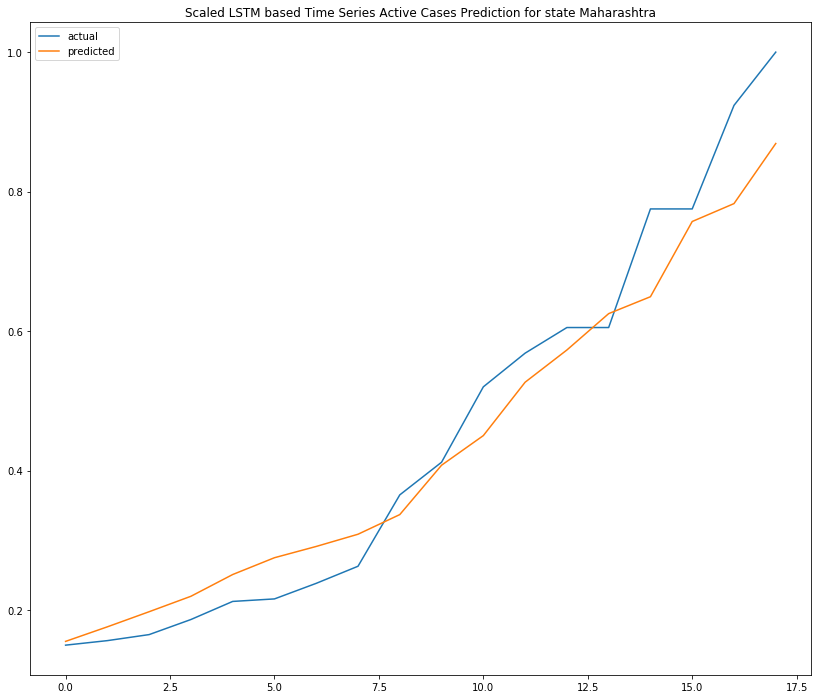

Test RMSE: 0.064


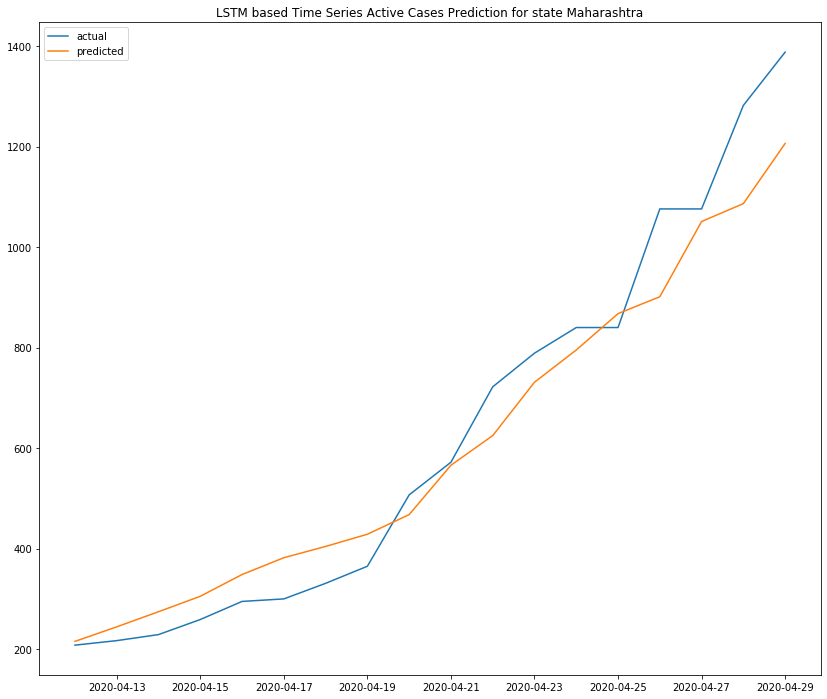

In [38]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)

# plot actual vs predicted
pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)

plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# Adding Smoothening factors (Rolling Window width 3) with limited Input features

52
(50, 22)
36
(36, 12)
(14, 12)
(36, 11) (36,) (14, 11) (14,)
(36, 1, 11) (36,) (14, 1, 11) (14,)
1 11
Train on 36 samples, validate on 14 samples
Epoch 1/2000
36/36 - 5s - loss: 0.0372 - val_loss: 0.5308
Epoch 2/2000
36/36 - 0s - loss: 0.0367 - val_loss: 0.5271
Epoch 3/2000
36/36 - 0s - loss: 0.0363 - val_loss: 0.5235
Epoch 4/2000
36/36 - 0s - loss: 0.0359 - val_loss: 0.5197
Epoch 5/2000
36/36 - 0s - loss: 0.0356 - val_loss: 0.5161
Epoch 6/2000
36/36 - 0s - loss: 0.0354 - val_loss: 0.5125
Epoch 7/2000
36/36 - 0s - loss: 0.0353 - val_loss: 0.5100
Epoch 8/2000
36/36 - 0s - loss: 0.0355 - val_loss: 0.5084
Epoch 9/2000
36/36 - 0s - loss: 0.0355 - val_loss: 0.5076
Epoch 10/2000
36/36 - 0s - loss: 0.0355 - val_loss: 0.5072
Epoch 11/2000
36/36 - 0s - loss: 0.0354 - val_loss: 0.5074
Epoch 12/2000
36/36 - 0s - loss: 0.0352 - val_loss: 0.5078
Epoch 13/2000
36/36 - 0s - loss: 0.0350 - val_loss: 0.5085
Epoch 14/2000
36/36 - 0s - loss: 0.0348 - val_loss: 0.5087
Epoch 15/2000
36/36 - 0s - loss: 0.

Epoch 137/2000
36/36 - 0s - loss: 0.0053 - val_loss: 0.1532
Epoch 138/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1537
Epoch 139/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1541
Epoch 140/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1542
Epoch 141/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1548
Epoch 142/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1553
Epoch 143/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1557
Epoch 144/2000
36/36 - 0s - loss: 0.0051 - val_loss: 0.1560
Epoch 145/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1568
Epoch 146/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1573
Epoch 147/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1576
Epoch 148/2000
36/36 - 0s - loss: 0.0051 - val_loss: 0.1581
Epoch 149/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1590
Epoch 150/2000
36/36 - 0s - loss: 0.0051 - val_loss: 0.1597
Epoch 151/2000
36/36 - 0s - loss: 0.0052 - val_loss: 0.1601
Epoch 152/2000
36/36 - 0s - loss: 0.0051 - val_loss: 0.1605
Epoch 153/2000
36/36 - 0s - loss: 0.0052

Epoch 274/2000
36/36 - 0s - loss: 0.0045 - val_loss: 0.1943
Epoch 275/2000
36/36 - 0s - loss: 0.0045 - val_loss: 0.1935
Epoch 276/2000
36/36 - 0s - loss: 0.0045 - val_loss: 0.1935
Epoch 277/2000
36/36 - 0s - loss: 0.0045 - val_loss: 0.1940
Epoch 278/2000
36/36 - 0s - loss: 0.0045 - val_loss: 0.1944
Epoch 279/2000
36/36 - 0s - loss: 0.0045 - val_loss: 0.1947
Epoch 280/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1952
Epoch 281/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1961
Epoch 282/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1971
Epoch 283/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1982
Epoch 284/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1974
Epoch 285/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1977
Epoch 286/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1963
Epoch 287/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1948
Epoch 288/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1940
Epoch 289/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.1938
Epoch 290/2000
36/36 - 0s - loss: 0.0044

Epoch 411/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.1946
Epoch 412/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.1935
Epoch 413/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.1958
Epoch 414/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.1955
Epoch 415/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.1926
Epoch 416/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.1924
Epoch 417/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.1950
Epoch 418/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.1957
Epoch 419/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.1937
Epoch 420/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.1942
Epoch 421/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.1960
Epoch 422/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.1952
Epoch 423/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.1922
Epoch 424/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.1918
Epoch 425/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.1939
Epoch 426/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.1958
Epoch 427/2000
36/36 - 0s - loss: 0.0041

Epoch 548/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1932
Epoch 549/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1951
Epoch 550/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1966
Epoch 551/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1976
Epoch 552/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.1967
Epoch 553/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.1964
Epoch 554/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.1953
Epoch 555/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.1935
Epoch 556/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.1946
Epoch 557/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1952
Epoch 558/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1954
Epoch 559/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1953
Epoch 560/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1953
Epoch 561/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1951
Epoch 562/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1947
Epoch 563/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.1939
Epoch 564/2000
36/36 - 0s - loss: 0.0039

Epoch 685/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2033
Epoch 686/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2028
Epoch 687/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2025
Epoch 688/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2019
Epoch 689/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2005
Epoch 690/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.2019
Epoch 691/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2029
Epoch 692/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2034
Epoch 693/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2036
Epoch 694/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2036
Epoch 695/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2037
Epoch 696/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2031
Epoch 697/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2022
Epoch 698/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2041
Epoch 699/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2049
Epoch 700/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2050
Epoch 701/2000
36/36 - 0s - loss: 0.0040

Epoch 822/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2076
Epoch 823/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2104
Epoch 824/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2118
Epoch 825/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.2120
Epoch 826/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2133
Epoch 827/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2150
Epoch 828/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2140
Epoch 829/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2105
Epoch 830/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2085
Epoch 831/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.2094
Epoch 832/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2091
Epoch 833/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2078
Epoch 834/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2095
Epoch 835/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2135
Epoch 836/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2146
Epoch 837/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2134
Epoch 838/2000
36/36 - 0s - loss: 0.0041

Epoch 959/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2162
Epoch 960/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2154
Epoch 961/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2146
Epoch 962/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2158
Epoch 963/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2161
Epoch 964/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2160
Epoch 965/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2162
Epoch 966/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2163
Epoch 967/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2156
Epoch 968/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2147
Epoch 969/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2164
Epoch 970/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2177
Epoch 971/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2180
Epoch 972/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2184
Epoch 973/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2189
Epoch 974/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2185
Epoch 975/2000
36/36 - 0s - loss: 0.0038

Epoch 1094/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2304
Epoch 1095/2000
36/36 - 0s - loss: 0.0048 - val_loss: 0.2307
Epoch 1096/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.2279
Epoch 1097/2000
36/36 - 0s - loss: 0.0043 - val_loss: 0.2268
Epoch 1098/2000
36/36 - 0s - loss: 0.0047 - val_loss: 0.2270
Epoch 1099/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2284
Epoch 1100/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.2283
Epoch 1101/2000
36/36 - 0s - loss: 0.0046 - val_loss: 0.2254
Epoch 1102/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2235
Epoch 1103/2000
36/36 - 0s - loss: 0.0045 - val_loss: 0.2245
Epoch 1104/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2282
Epoch 1105/2000
36/36 - 0s - loss: 0.0043 - val_loss: 0.2305
Epoch 1106/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.2296
Epoch 1107/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.2293
Epoch 1108/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2301
Epoch 1109/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2286
Epoch 1110/2000
36/36 - 

Epoch 1229/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2327
Epoch 1230/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2327
Epoch 1231/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2319
Epoch 1232/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2313
Epoch 1233/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2315
Epoch 1234/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.2308
Epoch 1235/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2297
Epoch 1236/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2314
Epoch 1237/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2322
Epoch 1238/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2320
Epoch 1239/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2327
Epoch 1240/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2334
Epoch 1241/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2331
Epoch 1242/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2327
Epoch 1243/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2334
Epoch 1244/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2329
Epoch 1245/2000
36/36 - 

Epoch 1364/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2361
Epoch 1365/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2383
Epoch 1366/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2402
Epoch 1367/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.2422
Epoch 1368/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2418
Epoch 1369/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2393
Epoch 1370/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2369
Epoch 1371/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2351
Epoch 1372/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2326
Epoch 1373/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2320
Epoch 1374/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2339
Epoch 1375/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2348
Epoch 1376/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2354
Epoch 1377/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2363
Epoch 1378/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2361
Epoch 1379/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2359
Epoch 1380/2000
36/36 - 

Epoch 1499/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2415
Epoch 1500/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2431
Epoch 1501/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2436
Epoch 1502/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2439
Epoch 1503/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2444
Epoch 1504/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2450
Epoch 1505/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2430
Epoch 1506/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2404
Epoch 1507/2000
36/36 - 0s - loss: 0.0040 - val_loss: 0.2390
Epoch 1508/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2400
Epoch 1509/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2415
Epoch 1510/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2418
Epoch 1511/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2413
Epoch 1512/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2415
Epoch 1513/2000
36/36 - 0s - loss: 0.0044 - val_loss: 0.2426
Epoch 1514/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2443
Epoch 1515/2000
36/36 - 

Epoch 1634/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2441
Epoch 1635/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2445
Epoch 1636/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2442
Epoch 1637/2000
36/36 - 0s - loss: 0.0039 - val_loss: 0.2433
Epoch 1638/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2446
Epoch 1639/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2465
Epoch 1640/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2474
Epoch 1641/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2475
Epoch 1642/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2483
Epoch 1643/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2490
Epoch 1644/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2474
Epoch 1645/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2454
Epoch 1646/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2443
Epoch 1647/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2436
Epoch 1648/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2422
Epoch 1649/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2432
Epoch 1650/2000
36/36 - 

Epoch 1769/2000
36/36 - 0s - loss: 0.0042 - val_loss: 0.2469
Epoch 1770/2000
36/36 - 0s - loss: 0.0041 - val_loss: 0.2453
Epoch 1771/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2460
Epoch 1772/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2489
Epoch 1773/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2509
Epoch 1774/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2521
Epoch 1775/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2533
Epoch 1776/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2523
Epoch 1777/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2508
Epoch 1778/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2496
Epoch 1779/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2477
Epoch 1780/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2462
Epoch 1781/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2468
Epoch 1782/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2486
Epoch 1783/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2503
Epoch 1784/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2516
Epoch 1785/2000
36/36 - 

Epoch 1904/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2525
Epoch 1905/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2514
Epoch 1906/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2509
Epoch 1907/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2499
Epoch 1908/2000
36/36 - 0s - loss: 0.0038 - val_loss: 0.2485
Epoch 1909/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2491
Epoch 1910/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2518
Epoch 1911/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2538
Epoch 1912/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2550
Epoch 1913/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2559
Epoch 1914/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2547
Epoch 1915/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2531
Epoch 1916/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2515
Epoch 1917/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2506
Epoch 1918/2000
36/36 - 0s - loss: 0.0036 - val_loss: 0.2497
Epoch 1919/2000
36/36 - 0s - loss: 0.0037 - val_loss: 0.2484
Epoch 1920/2000
36/36 - 

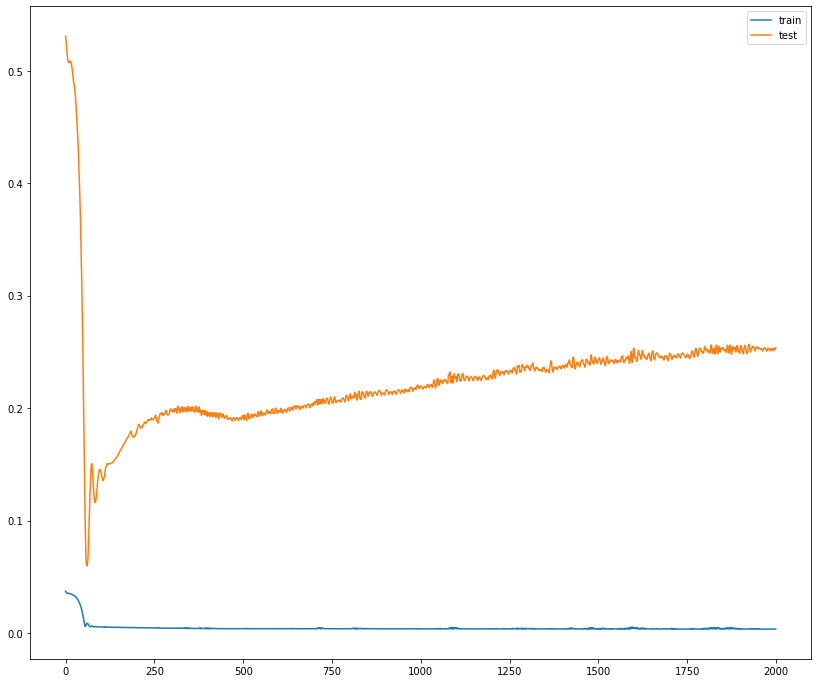

(36, 1, 11) (36,) (14, 11) (14,)


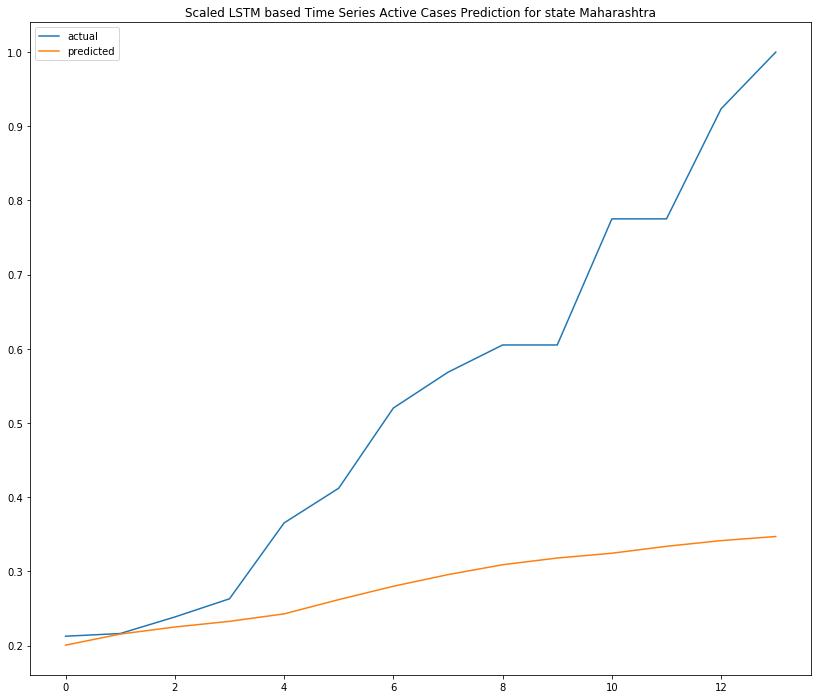

Test RMSE: 0.328
Test RMSE: 455.067


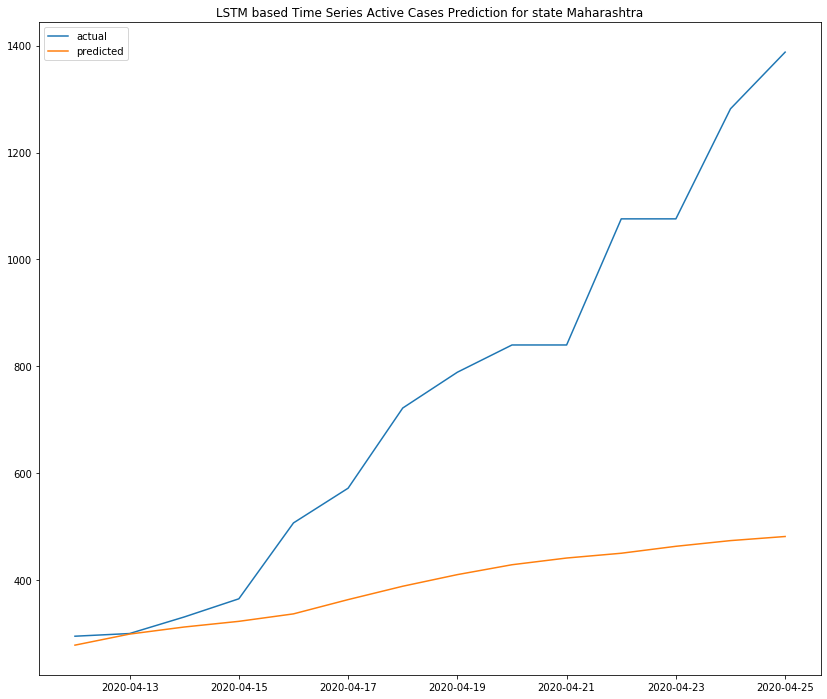

In [39]:
# convert series to supervised learning
def series_to_supervised_smoothing(data, n_in=1, n_out=1, dropnan=True):
    width = 2

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        lag3 = df.shift(width-1)
        rwm = lag3.rolling(window=width)
        means = rwm.mean()

        cols.append(means)
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


dataset =df_state_recs[9]
dataset = dataset[['Cured/Discharged/Migrated', 'Death', 'Total Confirmed cases', 'LiteracyRate', 'PopulationDensity', 'ElderlyRate',
       'DistrictsEffected', 'NoRedZones', 'NoOrangeZones', 'NoGreenZones', 'Active Cases']]


no_features = 10

values = dataset.values
# ensure all data is float
values = values.astype('float32')
print(np.shape(values)[0])
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised_smoothing(scaled, 1, 1)
# drop columns we don't want to predict
print(np.shape(reframed))
#reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.drop(reframed.columns[[12, 13, 14, 15, 16, 17, 18, 19, 20, 21]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_hours = int(df_per_State_features_lstm.shape[0]*0.70)
print(n_train_hours)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print(np.shape(train))
print(np.shape(test))

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

print(train_X.shape[1], train_X.shape[2])


# design network
model = Sequential()

model.add(LSTM(units=50, return_sequences= True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)

plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# Prediction for Tamil Nadu (Expanding Window width 3) with limited Input features

54
(50, 22)
33
(33, 12)
(17, 12)
(33, 11) (33,) (17, 11) (17,)
(33, 1, 11) (33,) (17, 1, 11) (17,)
1 11
Train on 33 samples, validate on 17 samples
Epoch 1/1250
33/33 - 5s - loss: 0.0056 - val_loss: 0.4581
Epoch 2/1250
33/33 - 0s - loss: 0.0054 - val_loss: 0.4562
Epoch 3/1250
33/33 - 0s - loss: 0.0059 - val_loss: 0.4556
Epoch 4/1250
33/33 - 0s - loss: 0.0061 - val_loss: 0.4562
Epoch 5/1250
33/33 - 0s - loss: 0.0058 - val_loss: 0.4572
Epoch 6/1250
33/33 - 0s - loss: 0.0055 - val_loss: 0.4584
Epoch 7/1250
33/33 - 0s - loss: 0.0052 - val_loss: 0.4597
Epoch 8/1250
33/33 - 0s - loss: 0.0051 - val_loss: 0.4608
Epoch 9/1250
33/33 - 0s - loss: 0.0059 - val_loss: 0.4604
Epoch 10/1250
33/33 - 0s - loss: 0.0057 - val_loss: 0.4593
Epoch 11/1250
33/33 - 0s - loss: 0.0051 - val_loss: 0.4582
Epoch 12/1250
33/33 - 0s - loss: 0.0051 - val_loss: 0.4574
Epoch 13/1250
33/33 - 0s - loss: 0.0052 - val_loss: 0.4567
Epoch 14/1250
33/33 - 0s - loss: 0.0052 - val_loss: 0.4562
Epoch 15/1250
33/33 - 0s - loss: 0.

Epoch 137/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3865
Epoch 138/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3862
Epoch 139/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3865
Epoch 140/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3866
Epoch 141/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3864
Epoch 142/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3860
Epoch 143/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3861
Epoch 144/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3863
Epoch 145/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3860
Epoch 146/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3857
Epoch 147/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3855
Epoch 148/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3858
Epoch 149/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3858
Epoch 150/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3854
Epoch 151/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3852
Epoch 152/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.3856
Epoch 153/1250
33/33 - 0s - loss: 0.0015

Epoch 274/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3745
Epoch 275/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3742
Epoch 276/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3737
Epoch 277/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3732
Epoch 278/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3732
Epoch 279/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3737
Epoch 280/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3741
Epoch 281/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3743
Epoch 282/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3745
Epoch 283/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3746
Epoch 284/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3747
Epoch 285/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3747
Epoch 286/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3746
Epoch 287/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3744
Epoch 288/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3742
Epoch 289/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3740
Epoch 290/1250
33/33 - 0s - loss: 0.0014

Epoch 411/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3597
Epoch 412/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3593
Epoch 413/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3580
Epoch 414/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3568
Epoch 415/1250
33/33 - 0s - loss: 0.0016 - val_loss: 0.3570
Epoch 416/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3573
Epoch 417/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3567
Epoch 418/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3560
Epoch 419/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3553
Epoch 420/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3549
Epoch 421/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3547
Epoch 422/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3545
Epoch 423/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3541
Epoch 424/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3529
Epoch 425/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3519
Epoch 426/1250
33/33 - 0s - loss: 0.0016 - val_loss: 0.3532
Epoch 427/1250
33/33 - 0s - loss: 0.0013

Epoch 548/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3398
Epoch 549/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3393
Epoch 550/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3366
Epoch 551/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3329
Epoch 552/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3306
Epoch 553/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3284
Epoch 554/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3260
Epoch 555/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.3231
Epoch 556/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3205
Epoch 557/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3183
Epoch 558/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3199
Epoch 559/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3214
Epoch 560/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3227
Epoch 561/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3238
Epoch 562/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.3240
Epoch 563/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.3241
Epoch 564/1250
33/33 - 0s - loss: 0.0012

Epoch 685/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2795
Epoch 686/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2780
Epoch 687/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2794
Epoch 688/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.2798
Epoch 689/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2803
Epoch 690/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2808
Epoch 691/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2814
Epoch 692/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2819
Epoch 693/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2825
Epoch 694/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2827
Epoch 695/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2806
Epoch 696/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2787
Epoch 697/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.2778
Epoch 698/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2771
Epoch 699/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.2755
Epoch 700/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.2734
Epoch 701/1250
33/33 - 0s - loss: 0.0012

Epoch 822/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2187
Epoch 823/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2157
Epoch 824/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2143
Epoch 825/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2163
Epoch 826/1250
33/33 - 0s - loss: 9.9846e-04 - val_loss: 0.2194
Epoch 827/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2200
Epoch 828/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2179
Epoch 829/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2137
Epoch 830/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2114
Epoch 831/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2124
Epoch 832/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2147
Epoch 833/1250
33/33 - 0s - loss: 9.9794e-04 - val_loss: 0.2145
Epoch 834/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.2119
Epoch 835/1250
33/33 - 0s - loss: 9.9621e-04 - val_loss: 0.2110
Epoch 836/1250
33/33 - 0s - loss: 9.9687e-04 - val_loss: 0.2116
Epoch 837/1250
33/33 - 0s - loss: 9.9172e-04 - val_loss: 0.2097
Epoch 838/1250
33/33

Epoch 955/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1703
Epoch 956/1250
33/33 - 0s - loss: 9.9567e-04 - val_loss: 0.1711
Epoch 957/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.1751
Epoch 958/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1771
Epoch 959/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.1737
Epoch 960/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.1657
Epoch 961/1250
33/33 - 0s - loss: 9.9289e-04 - val_loss: 0.1599
Epoch 962/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.1601
Epoch 963/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.1651
Epoch 964/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.1692
Epoch 965/1250
33/33 - 0s - loss: 0.0016 - val_loss: 0.1680
Epoch 966/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1623
Epoch 967/1250
33/33 - 0s - loss: 0.0016 - val_loss: 0.1625
Epoch 968/1250
33/33 - 0s - loss: 0.0018 - val_loss: 0.1679
Epoch 969/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.1753
Epoch 970/1250
33/33 - 0s - loss: 0.0015 - val_loss: 0.1773
Epoch 971/1250
33/33 - 0s - loss

Epoch 1084/1250
33/33 - 0s - loss: 9.6877e-04 - val_loss: 0.1186
Epoch 1085/1250
33/33 - 0s - loss: 9.9412e-04 - val_loss: 0.1142
Epoch 1086/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1123
Epoch 1087/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1128
Epoch 1088/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1151
Epoch 1089/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1188
Epoch 1090/1250
33/33 - 0s - loss: 9.8477e-04 - val_loss: 0.1239
Epoch 1091/1250
33/33 - 0s - loss: 9.8453e-04 - val_loss: 0.1283
Epoch 1092/1250
33/33 - 0s - loss: 9.9857e-04 - val_loss: 0.1276
Epoch 1093/1250
33/33 - 0s - loss: 9.5829e-04 - val_loss: 0.1287
Epoch 1094/1250
33/33 - 0s - loss: 9.6095e-04 - val_loss: 0.1312
Epoch 1095/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1315
Epoch 1096/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1271
Epoch 1097/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1183
Epoch 1098/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1108
Epoch 1099/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1

Epoch 1214/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1349
Epoch 1215/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.1349
Epoch 1216/1250
33/33 - 0s - loss: 0.0016 - val_loss: 0.1302
Epoch 1217/1250
33/33 - 0s - loss: 0.0012 - val_loss: 0.1211
Epoch 1218/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.1154
Epoch 1219/1250
33/33 - 0s - loss: 0.0014 - val_loss: 0.1150
Epoch 1220/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1163
Epoch 1221/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1182
Epoch 1222/1250
33/33 - 0s - loss: 0.0013 - val_loss: 0.1198
Epoch 1223/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1218
Epoch 1224/1250
33/33 - 0s - loss: 9.9205e-04 - val_loss: 0.1251
Epoch 1225/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1300
Epoch 1226/1250
33/33 - 0s - loss: 9.6959e-04 - val_loss: 0.1357
Epoch 1227/1250
33/33 - 0s - loss: 0.0010 - val_loss: 0.1369
Epoch 1228/1250
33/33 - 0s - loss: 0.0011 - val_loss: 0.1339
Epoch 1229/1250
33/33 - 0s - loss: 9.9065e-04 - val_loss: 0.1272
Epoch 1230/1

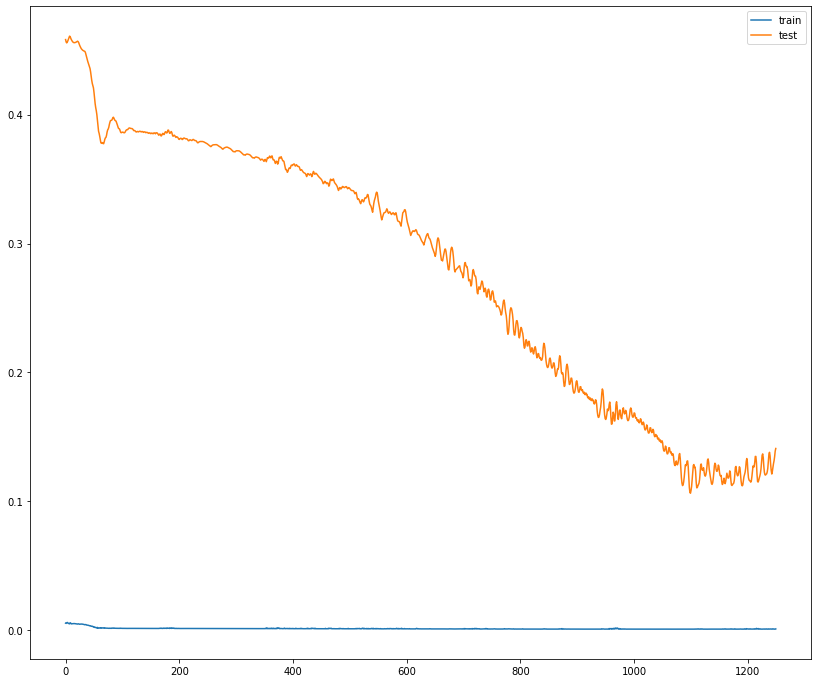

(33, 1, 11) (33,) (17, 11) (17,)


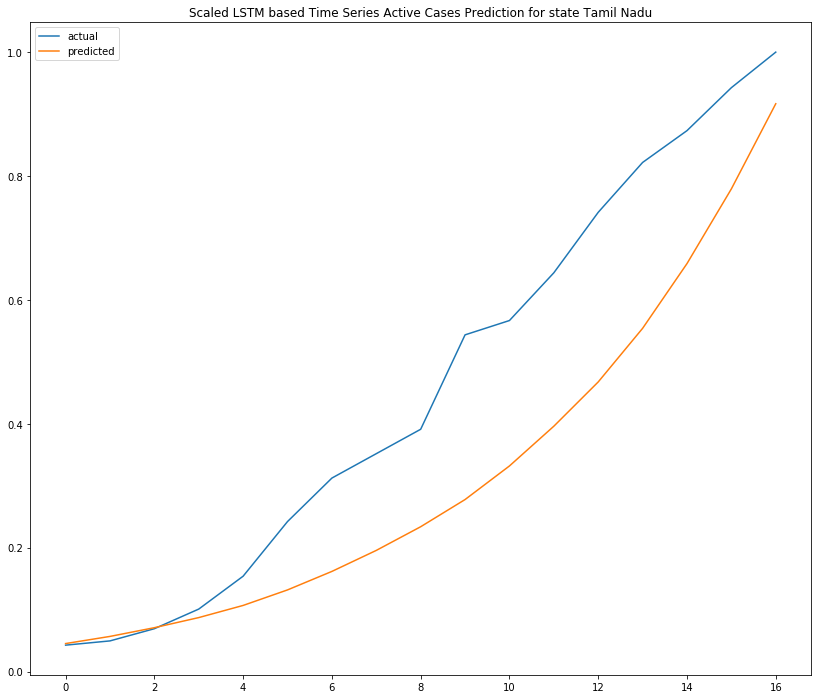

Test RMSE: 0.171
Test RMSE: 200.290


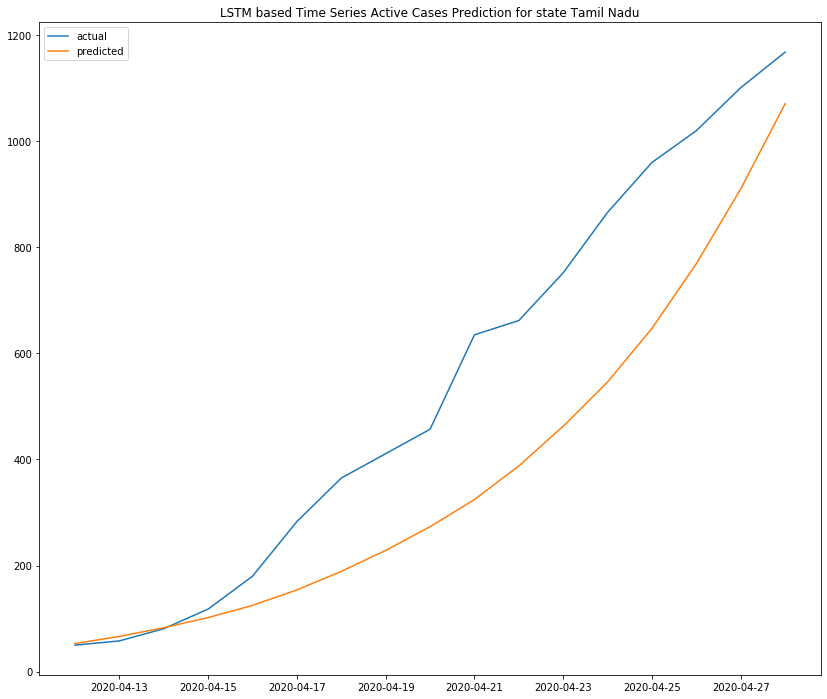

In [40]:
# convert series to supervised learning
def series_to_supervised_smoothing(data, n_in=1, n_out=1, dropnan=True):
    width = 3

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        lag3 = df.shift(width-1)
        rwm = lag3.expanding(width)
        means = rwm.mean()

        cols.append(means)
        names += [('feature%d(ti-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('feature%d(ti)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('feature%d(ti+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


dataset =df_state_recs[6]
stateName = states[6]
dataset = dataset[['Cured/Discharged/Migrated', 'Death', 'Total Confirmed cases', 'LiteracyRate', 'PopulationDensity', 'ElderlyRate',
       'DistrictsEffected', 'NoRedZones', 'NoOrangeZones', 'NoGreenZones', 'Active Cases']]


no_features = 10

values = dataset.values

# ensure all data is float
values = values.astype('float32')
print(np.shape(values)[0])
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised_smoothing(scaled, 1, 1)
# drop columns we don't want to predict
print(np.shape(reframed))
#reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.drop(reframed.columns[[12, 13, 14, 15, 16, 17, 18, 19, 20, 21]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(df_per_State_features_lstm.shape[0]*0.65)
print(split_factor)
train = values[:split_factor, :]
test = values[split_factor:, :]

print(np.shape(train))
print(np.shape(test))

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

print(train_X.shape[1], train_X.shape[2])


# design network
model = Sequential()

model.add(LSTM(units=50, return_sequences= True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=1250, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

In [41]:
print(pred_index)

DatetimeIndex(['2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27',
               '2020-04-28'],
              dtype='datetime64[ns]', freq='D')
